### Inception Net
- 모바일 및 임베디드 컴퓨팅 환경에서의 효율성을 강조하며, 15억 곱하기 덧셈의 계산 예산으로 설계.
- ILSVRC 2014 성과: 분류 및 탐지 과제에서 최첨단 성능을 달성.
- 계산 복잡도: 각 단계에서 출력 횟수를 효율적으로 증가시키면서도 계산 복잡도를 크게 증가시키지 않음.

- **GoogLeNet의 훈련 및 성능**
  - 비동기 확률적 경사 하강 및 Polyak 평균화를 사용하는 DistBelief 시스템으로 훈련.
  - 외부 훈련 데이터 없이도 ILSVRC 2014에서 최첨단 결과를 달성했습니다.

- **앙상블 및 개선**
  - 앙상블 모델: 7개의 독립적으로 훈련된 모델을 사용하여 분류 정확도를 향상시켰습니다.
  - 객체 검출: 컨볼루션 네트워크를 통한 객체 검출 정확도가 크게 향상되었습니다.

### Inception Net 구조
  ![AC](https://miro.medium.com/v2/resize:fit:1276/1*63ZlzSqS851I3nW89PUVlg.jpeg)
- 1 x 1 합성 곱, 3 x 3 합성 곱, 5 x 5 합성 곱, 3 x 3 최대 풀링 층을 병렬로 처리 (Concat)
- 층이 깊어지고 파라미터가 늘어남에 따라 경사 소실 문제 발생하는데 의 대비책
- 전체 Loss: $$\text{total loss} = \text{real loss} + (\text{weight 1} \times \text{aux loss}_1) + (\text{weight 2} \times \text{aux loss}_2)$$

- bottle neck 구조
- Inception module
  ![inception_Module](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_3.22.39_PM.png)



In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from matplotlib.pyplot import imshow
import math
import numpy as np
from glob import glob

### 인셉션 모듈 구조 확인

In [25]:
def inception_module(input_tensor, filters_1x1, filters_3x3, filters_5x5, filters_pool):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(input_tensor)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(input_tensor)
    
    max_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, max_pool])

    return output

def inception_module_1_1_added(input_tensor, filters_1x1, filters_3x3, filters_5x5, filters_pool):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(input_tensor)

    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(input_tensor)
    conv_3x3 = Conv2D(np.int64(filters_3x3/2), (1, 1), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(np.int64(filters_5x5/2), (1, 1), padding='same', activation='relu')(conv_5x5)
    
    max_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    max_pool = Conv2D(1, (1, 1), padding='same', activation='relu')(max_pool)

    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, max_pool])

    return output

In [14]:
input_tensor = Input(shape=(224, 224, 3))
output_tensor = inception_module(input_tensor, 64, 128, 32, 32)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 224, 224,  │        256 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 224, 224,  │      3,584 │ input_layer_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 224, 224,  │      2,432 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 224, 224,  │          0 │ conv2d_188[0][0], │
│ (Concatenate)       │ 227)              │            │ conv2d_189[0][0], │
│                     │                   │            │ conv2d_190[0][0], │
│                     │                   │            │ max_pooling2d_8[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,272 (24.50 KB)

 Trainable params: 6,272 (24.50 KB)

 Non-trainable params: 0 (0.00 B)

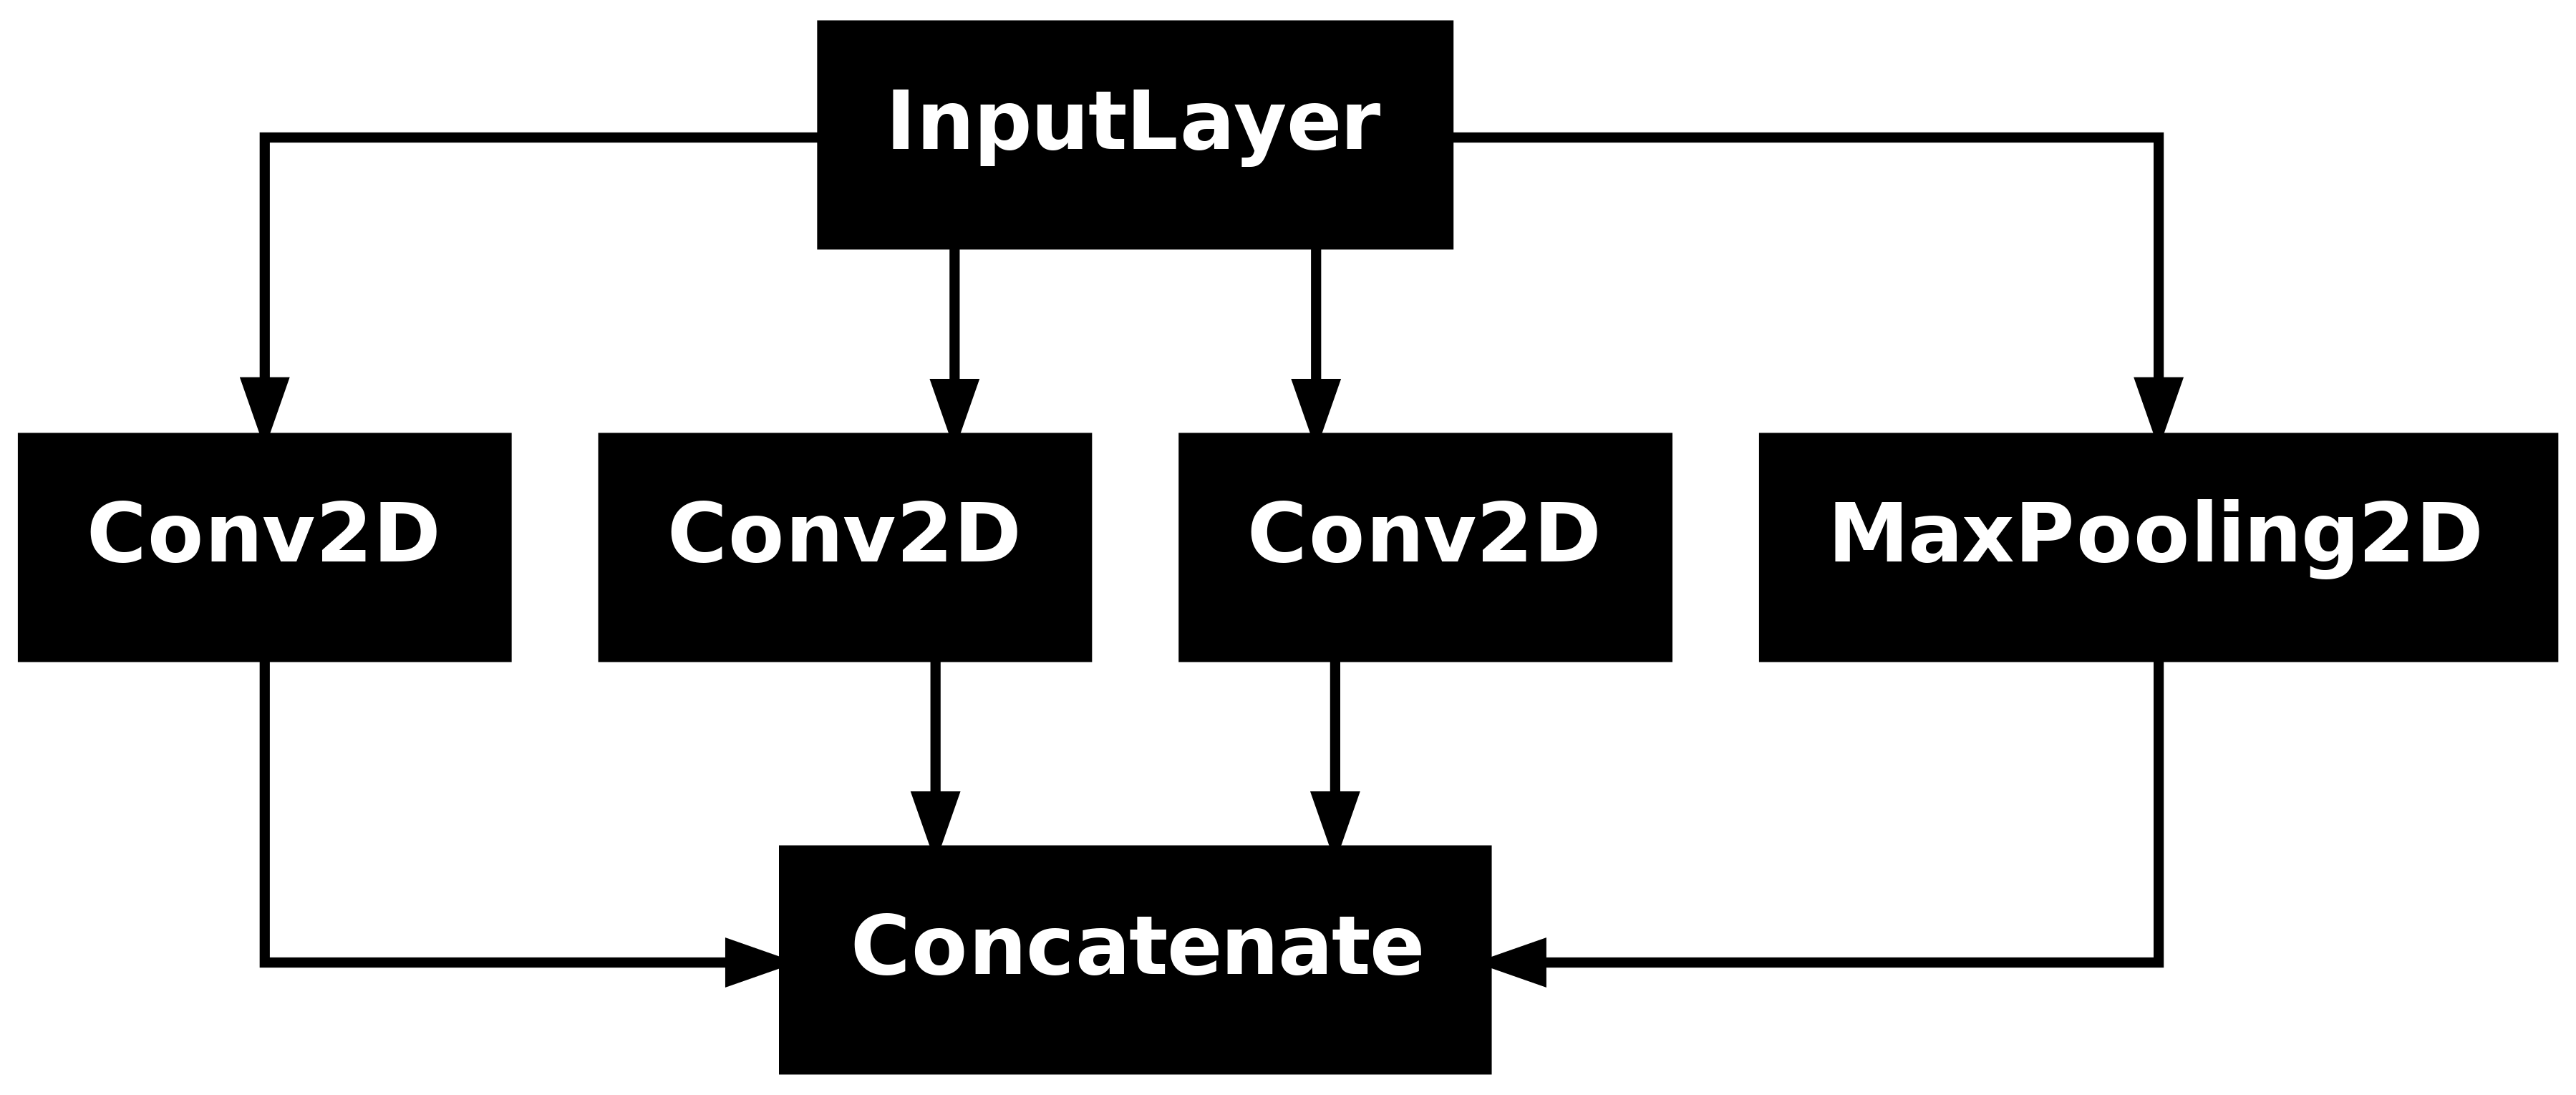

In [19]:
from keras.utils import plot_model

plot_model(
    model,
    # to_file="model.png",
    show_shapes=False,
    show_layer_names=False,
    rankdir="TB", expand_nested=True, dpi=512,
    show_layer_activations=False,)

In [27]:
input_tensor = Input(shape=(224, 224, 3))
output_tensor2 = inception_module_1_1_added(input_tensor, 64, 128, 32, 32)

model2 = Model(inputs=input_tensor, outputs=output_tensor2)
model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_210 (Conv2D) │ (None, 224, 224,  │      3,584 │ input_layer_10[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_212 (Conv2D) │ (None, 224, 224,  │      2,432 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_209 (Conv2D) │ (None, 224, 224,  │        256 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_211 (Conv2D) │ (None, 224, 224,  │      8,256 │ conv2d_210[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_213 (Conv2D) │ (None, 224, 224,  │        528 │ conv2d_212[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_214 (Conv2D) │ (None, 224, 224,  │          4 │ max_pooling2d_10… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 224, 224,  │          0 │ conv2d_209[0][0], │
│ (Concatenate)       │ 145)              │            │ conv2d_211[0][0], │
│                     │                   │            │ conv2d_213[0][0], │
│                     │                   │            │ conv2d_214[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,060 (58.83 KB)

 Trainable params: 15,060 (58.83 KB)

 Non-trainable params: 0 (0.00 B)

각 클래스의 이미지들이 저장되어 있는 폴더에서 데이터 불러오기 <br>
InceptionNet 입력 포맷 : 299x299

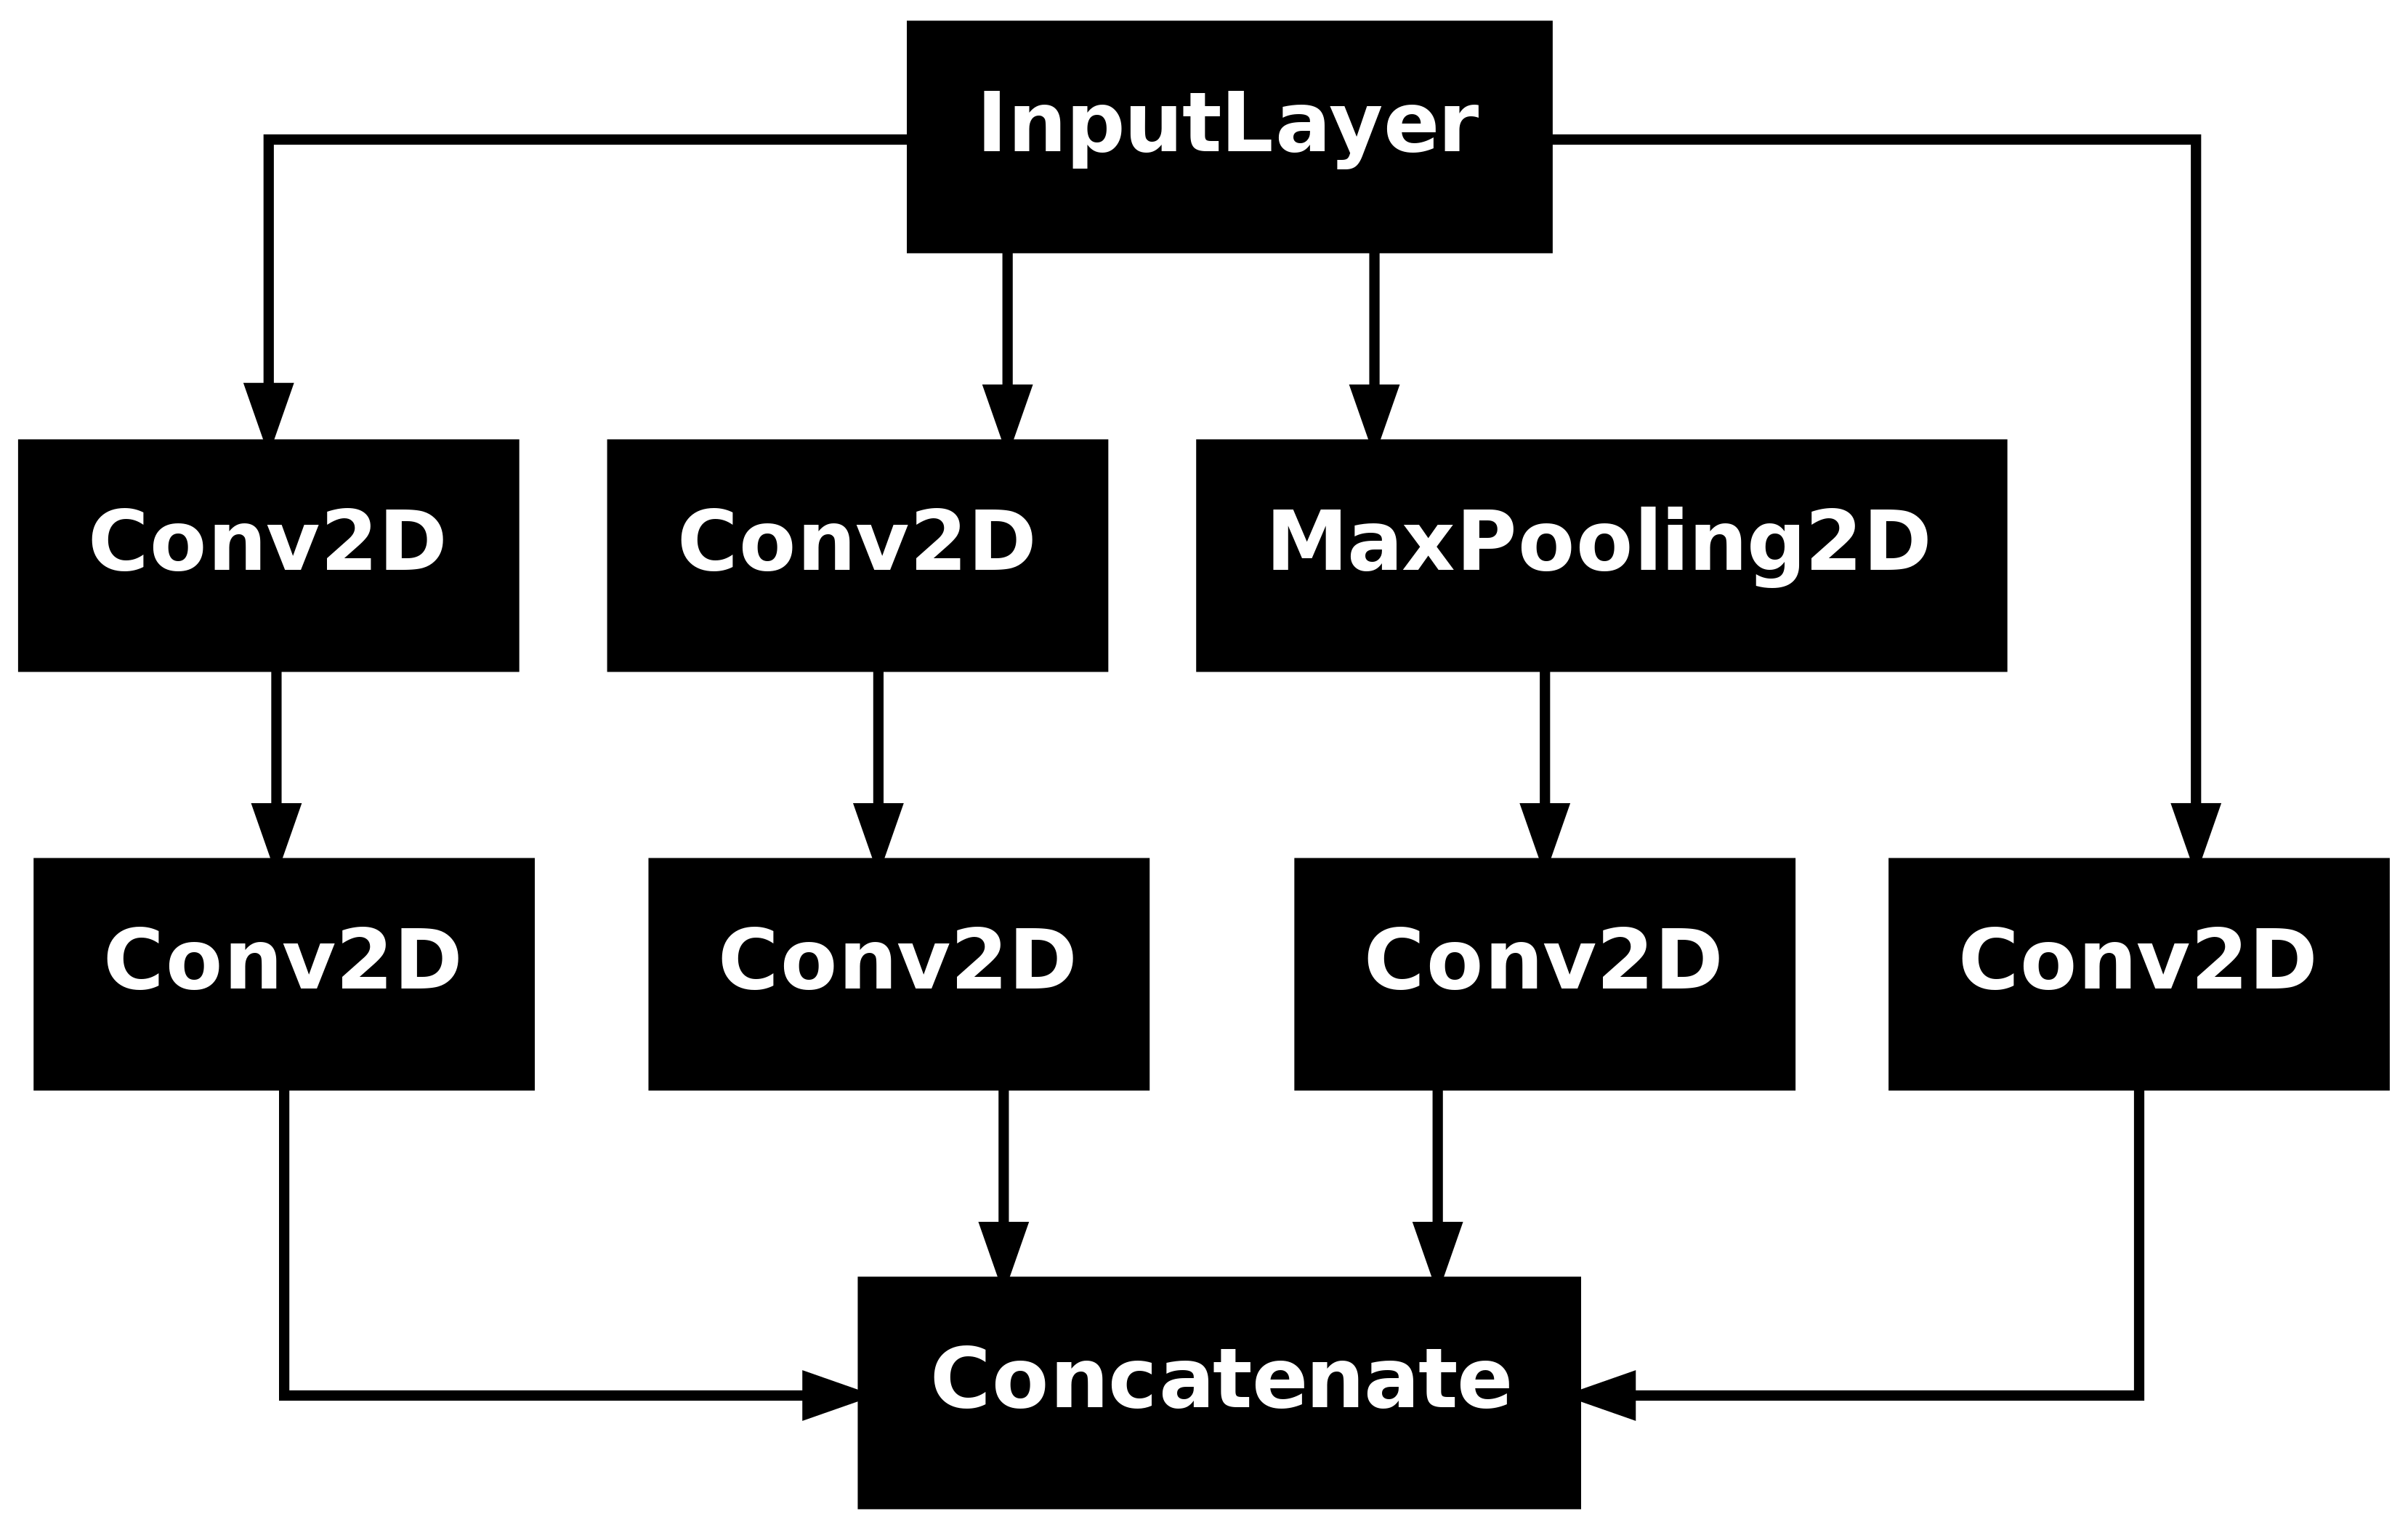

In [29]:

# Ensure `model` is defined and built
plot_model(
    model2,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=512,
    show_layer_activations=False)

In [4]:
all_globs = glob('data/imgs/data_mw/man/*jpg') + glob('data/imgs/data_mw/woman/*jpg')

images = []
for p in all_globs:
    try:
        images.append(image.load_img(p, target_size=(299, 299)))
    except:
        pass

vector = np.asarray([image.img_to_array(img) for img in images])
# glob() : 특정 폴더에 존재하는 파일들의 경로를 읽어 옮

In [ ]:
vector.shape

- InceptionNet (version3) 호출

In [6]:
base_model = InceptionV3(weights='imagenet', include_top=True)

In [ ]:
base_model.summary()

- 합성곱층 (convolutional layers) 부분에서 출력하는 feature 정보
- 합성곱층에 해당하는 부분만 추출.
- Model 클래스를 이용해서 입력부분과 출력부분 지정

In [8]:
basic_model1 = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)


# inputs=base_model : InceptionV3 모델의 입력과 동일

# outputs=base_model.get_layer('avg_pool').output:
       # 모델의 출력 InceptionV3 모델의 'avg_pool' 레이어의 출력

In [ ]:
basic_model1.summary()

In [10]:
from keras.utils import plot_model

# Ensure `model` is defined and built
plot_model(base_model, #base_model1
           # to_file="model.png",
           show_shapes=False,
           show_layer_names=False,
    rankdir="TB", expand_nested=False, dpi=512,
    show_layer_activations=False,)

In [ ]:
# avg_pool 층이 출력하는 feature 정보를 얻음
# preprocess_input() : 입력 데이터 값 normalization
vectors = basic_model1.predict(preprocess_input(vector))
vectors.shape #이미지 별 2048개의 피처 정보

In [ ]:
# vectors1 = basic_model1.predict(vector/255) #예측


종속변수 생성 <--- 폴더 정보 사용 <br>
‘b’ 폴더에 있는 이미지의 종속변수 값을 1로 , <br>
‘e’ 폴더에 있는 이미지의 종속변수 값을 0으로

In [ ]:
# labels = [1] * 179 + [0] * 142
# b => 1, e => 0 으로 labeling
# 첫번째 폴더에 존재하는 이미지들(b)의 정답을 1로,
# 두번째 폴더에 존재하는 이미지들(e)의 정답을 0으로 설정
labels =  [1] * (glob('data/imgs/data_mw/man/*jpg').__len__()-1)\
        + [0] * glob('data/imgs/data_mw/woman/*jpg').__len__()

In [ ]:
# 학습 데이터와 평가 데이터 구분
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2)

In [ ]:
# 레이어들의 최상단이후 Logistic Regression 으로 분류
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# l1 및 l2 규제 (가중치 규제 : 과적합 방지책)

lr_p1 = LogisticRegression(C=1, penalty='l1', solver='saga', max_iter=10000)
lr_p1.fit(X_train, y_train)

lr_p2 = LogisticRegression(C=1, penalty='l2', solver='saga', max_iter=1000)
lr_p2.fit(X_train, y_train)

lr_p1.score(X_test, y_test), lr_p2.score(X_test, y_test)

In [ ]:
import numpy as np
np.set_printoptions(suppress=True, precision=10)
lr_p2.predict_proba(vectors[0].reshape(1, -1))

In [ ]:
lr_p2.predict(vectors[0].reshape(1, -1))

In [ ]:
imshow(np.asarray(images[0]))

### inception net + 머신러닝 분류 알고리즘 적용
- 사용된 알고리즘
    - DecisionTreeClassifier
    - AdaBoostClassifier
    - RandomForestClassifier
    - LogisticRegression
    - SVC (Support Vector Classifier)
    - GaussianNB (Naive Bayes)
    - KNeighborsClassifier
    - GradientBoostingClassifier
    - ExtraTreesClassifier
    - HistGradientBoostingClassifier
    - LinearDiscriminantAnalysis
    - QuadraticDiscriminantAnalysis
    - BaggingClassifier
    - RidgeClassifier
    - Perceptron
    - MLPClassifier (Multi-layer Perceptron)
    - GaussianProcessClassifier
    - ComplementNB (Naive Bayes)
    - BernoulliNB (Naive Bayes)
    - NuSVC (Nu Support Vector Classifier)
    - LinearSVC (Linear Support Vector Classifier)
    - XGBoost (XGBoost Classifier)

In [ ]:
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
models = [LinearSVC() ,MLPClassifier() ,GaussianProcessClassifier() ,LogisticRegression(), SVC(probability=True), GaussianNB(), DecisionTreeClassifier(),
          RandomForestClassifier(), KNeighborsClassifier(), GradientBoostingClassifier(),
          AdaBoostClassifier(), ExtraTreesClassifier(), HistGradientBoostingClassifier(),
          LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), BaggingClassifier(),
          RidgeClassifier(), Perceptron(), MLPClassifier(), GaussianProcessClassifier(),
          ComplementNB(), BernoulliNB(), NuSVC(), xgb.XGBClassifier()]

best_model_score = 0
model_over_85 = []


for model in models:
    model.fit(X_train,y_train)
    model_score = model.score(X_test,y_test)
    
    model_name = str(model)[:25].ljust(25)
    f1 = f1_score(y_test, model.predict(X_test))

    print(f'모델 이름 {model_name}',end=', ')
    print('정확도:', model.score(X_test,y_test), end=', ')
    print(f'f1 스코어 점수 : {f1:0.5f}')

    if best_model_score < model_score:
        best_model_score = model_score
        best_model = model

In [ ]:
best_model, best_model_score

In [ ]:
def inception_module(input_tensor, filters_1x1, filters_3x3, filters_5x5, filters_pool):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(input_tensor)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(input_tensor)
    
    max_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, max_pool])

    return output

def inception_module_1_1_added(input_tensor, filters_1x1, filters_3x3, filters_5x5, filters_pool):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(input_tensor)

    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(input_tensor)
    conv_3x3 = Conv2D(filters_3x3/2, (1, 1), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(filters_5x5/2, (1, 1), padding='same', activation='relu')(conv_5x5)
    
    max_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    max_pool = Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(max_pool)

    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, max_pool])

    return output

In [ ]:

input_tensor = Input(shape=(224, 224, 3))
output_tensor = inception_module(input_tensor, 64, 128, 32, 32)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.summary()

In [ ]:

input_tensor = Input(shape=(224, 224, 3))
output_tensor2 = inception_module_1_1_added(input_tensor, 64, 128, 32, 32)

model2 = Model(inputs=input_tensor, outputs=output_tensor2)
model2.summary()

In [ ]:
from keras.utils import plot_model

# Ensure `model` is defined and built
plot_model(model, to_file="model.png", show_shapes=False, show_layer_names=False,
    rankdir="TB", expand_nested=False, dpi=512,
    show_layer_activations=False,)

In [ ]:

# Ensure `model` is defined and built
plot_model(model2, to_file="model.png", show_shapes=False, show_layer_names=False,
    rankdir="TB", expand_nested=False, dpi=512,
    show_layer_activations=False,)

In [ ]:
input_tensor = Input(shape=(224, 224, 3))
output_tensor3 = inception_module_1_1_added(input_tensor, 64, 128, 32, 32)
output_tensor3 = inception_module_1_1_added(output_tensor3, 64, 128, 32, 32)

model3 = Model(inputs=input_tensor, outputs=output_tensor3)
model3.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model3, to_file="model.png", show_shapes=False, show_layer_names=False,
    rankdir="TB", expand_nested=False, dpi=128,
    show_layer_activations=False,)